In [1]:
from ImageProcessor import *
from Evaluation import * 
svs_path = '../prelimary_data/BRACS_1494.svs'
json_path = '../prelimary_data/BRACS_1494.geojson'
tile_size = 512

imageProcessor_1494 = ImageProcessor(json_path, svs_path)
tiles_1494 = imageProcessor_1494.generate_tile(tile_size = tile_size)

/home/s4647285/STAT3007/combined_scripts/ImageProcessor.py:82: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersections_df = geopandas.overlay(tiles_df, annotations_df, how='intersection')
100%|██████████| 166/166 [04:30<00:00,  1.63s/it]


In [2]:
svs_path = '../prelimary_data/BRACS_1496.svs'
json_path = '../prelimary_data/BRACS_1496.geojson'
imageProcessor_1496 = ImageProcessor(json_path, svs_path)
tiles_1496 = imageProcessor_1496.generate_tile(tile_size = tile_size)

100%|██████████| 174/174 [05:01<00:00,  1.73s/it]


In [3]:
svs_path = '../prelimary_data/BRACS_1286.svs'
json_path = '../prelimary_data/BRACS_1286.geojson'
imageProcessor_1286 = ImageProcessor(json_path, svs_path)
tiles_1286 = imageProcessor_1286.generate_tile(tile_size = tile_size)

100%|██████████| 173/173 [05:52<00:00,  2.04s/it]


In [4]:
tiles = tiles_1494 + tiles_1496 + tiles_1286

In [5]:
len(tiles)

49616

In [6]:
import random
import numpy as np
import torch

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds(32)

In [7]:
tiles = [t for t in tiles if t.image_data.shape == (3, tile_size, tile_size)]
tiles_copy = tiles
tiles_with_masks = [t for t in tiles if 1 in t.mask]
print(len(tiles_with_masks))
tiles = tiles_with_masks + list(np.random.choice(tiles, 3*len(tiles_with_masks), replace=False))
print(len(tiles))

743
2972


In [12]:
# # tiles_with_masks = [t for t in tiles if 1 in t.mask]
# # print(len(tiles_with_masks))
# # tiles = tiles_with_masks + list(np.random.choice(tiles, 3*len(tiles_with_masks), replace=False))
# # print(len(tiles))
# tiles_with_masks = [t for t in tiles if 1 in t.mask]
# tiles = tiles_with_masks + list(np.random.choice(tiles, len(tiles_with_masks), replace=False))

In [14]:
import torch
import segmentation_models_pytorch as smp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = [1]
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# import segmentation_models_pytorch as smp

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    decoder_use_batchnorm=True,
    encoder_depth=4,
    decoder_channels=(256, 128, 64, 32),
)

In [19]:
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from numpy import random

def generate_random_rng_state():
    random_seed = random.randint(0, 2**32 - 1)
    torch.manual_seed(random_seed)
    rng_state = torch.get_rng_state()
    return rng_state

class TiledWSIDataset(Dataset):
    def __init__(self, tiles, length_modifier=1.0, training=True):
        self.tiles = [t.image_data for t in tiles]
        self.masks = [t.mask for t in tiles]
        self.general_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            #transforms.RandomRotation(degrees=(-90, 90)),
        ])
        self.image_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
            #transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1.0, 2.0))
        ])
        self.length_modifier = length_modifier
        self.random_state = [generate_random_rng_state()] * int(len(self.tiles) * self.length_modifier)
        self.training = training

    def __len__(self):
        return int(self.length_modifier * len(self.tiles))

    def __getitem__(self, idx):
        image = self.tiles[idx % len(self.tiles)]
        image = image.transpose(1, 2, 0)

        mask = self.masks[idx % len(self.tiles)]

        mask_rgb = np.repeat(mask, 3, axis=0)
        mask_rgb = torch.tensor(mask_rgb)

        image = self.image_transform(image)

        if self.training:
          state = self.random_state[idx]
          torch.set_rng_state(state)
          image = self.general_transform(image)

          torch.set_rng_state(state)
          mask_rgb = self.general_transform(mask_rgb)

        mask = mask_rgb[0]
        mask = mask.unsqueeze(0)

        return image, mask

dataset = TiledWSIDataset(tiles, length_modifier=1.5)
full_dataset = DataLoader(dataset, batch_size=16, shuffle=True)

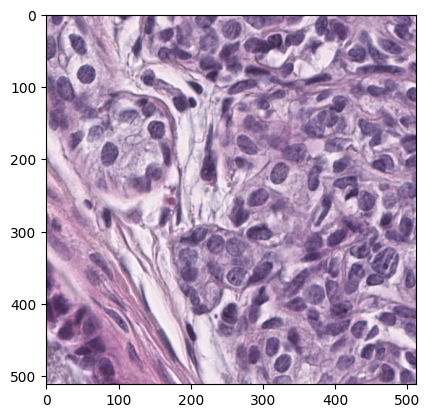

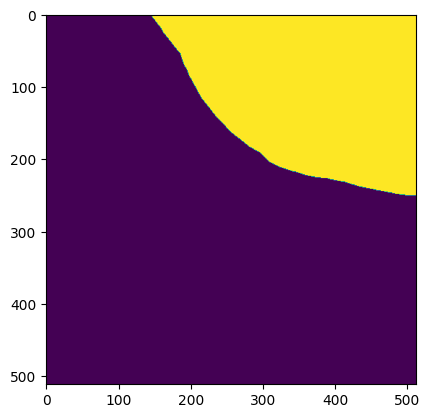

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 512, 512])


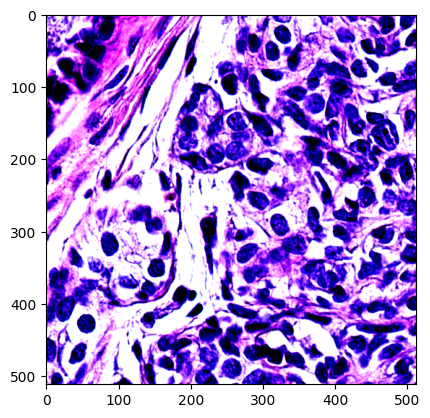

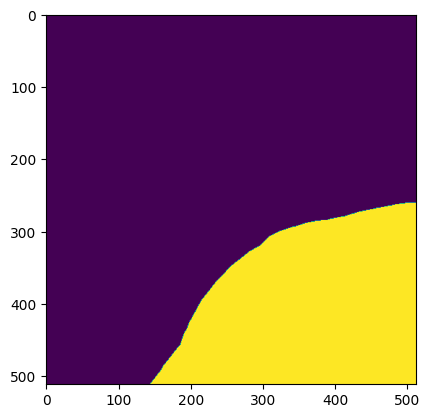

In [10]:
i = 223

image1, mask1 = tiles[i].image_data, tiles[i].mask

import matplotlib.pyplot as plt

plt.imshow(image1.transpose(1, 2, 0))
plt.show()
plt.imshow(mask1.transpose(1, 2, 0))
plt.show()

image2, mask2 = dataset[i]
print(mask2.shape)
plt.imshow(image2.permute(1, 2, 0))
plt.show()
plt.imshow(mask2.squeeze(0))
plt.show()

In [11]:
from torch.utils.data import random_split, DataLoader
from torch.optim import Adam

# Split the smaller dataset into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
test_dataset.training = False
train_dataset.training = True

batch_size = 4

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)


In [12]:
print(test_size)

892


In [45]:


# model = model.to(device)

# lr = (1e-6)
# optimizer = Adam(model.parameters(), lr=lr)

# criterion1 = nn.BCEWithLogitsLoss()
# # criterion2 = smp.losses.DiceLoss(mode='binary')

# # def criterion(outputs, labels):
# #   global criterion1, criterion2
# #   return 0.5 * nn.BCEWithLogitsLoss()(outputs, labels) + 0.5 * smp.losses.DiceLoss(mode='binary')(outputs, labels)

# def train(model, trainloader, testloader, criterion, optimizer, epochs, device):
#   best_test = np.inf
#   training_losses = []
#   test_losses = []
#   for epoch in range(epochs):
#     epoch_loss = 0
#     test_loss = 0

#     model.train()
#     for images, masks in tqdm(trainloader):

#       images, masks = images.to(device), masks.to(device)

#       optimizer.zero_grad()

#       outputs = model(images)

#       loss = criterion(outputs, masks)
#       loss.backward()
#       optimizer.step()
#       loss = loss.cpu()
#       epoch_loss += loss.item()

#     model.eval()
#     for image, masks in tqdm(testloader):
#       images, masks = images.to(device), masks.to(device)
#       outputs = model(images)
#       loss = criterion(outputs, masks)
#       loss = loss.cpu()
#       test_loss += loss.item()

#     if test_loss/len(testloader) < best_test:
#       best_test = test_loss/len(testloader)
#       torch.save(model.state_dict(), 'unet.pth')

#     print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(trainloader)}, Test Loss: {test_loss/len(testloader)}')
#     training_losses.append(epoch_loss/len(trainloader))
#     test_losses.append(test_loss/len(testloader))

#   return training_losses, test_losses


In [17]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 1e-6
optimizer = Adam(model.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss()

def train(model, trainloader, testloader, criterion, optimizer, epochs, device):
  best_test = np.inf
  train_losses = []
  test_losses = []


  for epoch in range(epochs):
    epoch_loss = 0
    test_loss = 0

    model.train()
    for images, masks in tqdm(trainloader):

      images, masks = images.to(device), masks.to(device)

      optimizer.zero_grad()

      outputs = model(images)

      loss = criterion(outputs, masks)
      loss.backward()
      optimizer.step()
      loss = loss.cpu()
      epoch_loss += loss.item()

    model.eval()
    for image, masks in tqdm(testloader):
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)
      loss = criterion(outputs, masks)
      loss = loss.cpu()
      test_loss += loss.item()

      
    epoch_train_loss = epoch_loss / len(trainloader)
    epoch_test_loss = test_loss / len(testloader)

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)

    if test_loss/len(testloader) < best_test:
      best_test = test_loss/len(testloader)
      lr_str = str(lr)
      tile_size_str = str(tile_size)
      torch.save(model.state_dict(), 'smp_' + lr_str + "_" + tile_size_str + 'pth')

    print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(trainloader)}, Test Loss: {test_loss/len(testloader)}')

  return train_losses, test_losses

    # plt.figure(figsize=(10, 5))
    # plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='red')
    # plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='blue')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title('Train and Test Loss Over Epochs')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


In [20]:
trained = train(model, train_loader, test_loader, criterion, optimizer, 50, device)

100%|██████████| 223/223 [00:08<00:00, 27.31it/s]


Epoch 1, Train Loss: 0.8795539806319942, Test Loss: 0.8297611167612632


100%|██████████| 223/223 [00:08<00:00, 26.22it/s]


Epoch 2, Train Loss: 0.8218068638367017, Test Loss: 0.8332827174075516


100%|██████████| 223/223 [00:08<00:00, 27.06it/s]


Epoch 3, Train Loss: 0.7946107396239249, Test Loss: 0.8303918012589082


100%|██████████| 223/223 [00:08<00:00, 26.73it/s]


Epoch 4, Train Loss: 0.7784235391820186, Test Loss: 0.8268676205066288


100%|██████████| 223/223 [00:08<00:00, 25.88it/s]


Epoch 5, Train Loss: 0.766392533693517, Test Loss: 0.8527562588854221


100%|██████████| 223/223 [00:08<00:00, 26.89it/s]


Epoch 6, Train Loss: 0.7593860182697926, Test Loss: 0.7744998645889385


100%|██████████| 223/223 [00:08<00:00, 26.15it/s]


Epoch 7, Train Loss: 0.7528468529650927, Test Loss: 0.7454388152323497


100%|██████████| 223/223 [00:08<00:00, 26.45it/s]


Epoch 8, Train Loss: 0.7481379605302907, Test Loss: 0.7292363715813299


100%|██████████| 223/223 [00:08<00:00, 26.30it/s]


Epoch 9, Train Loss: 0.744187922790797, Test Loss: 0.7812952169388399


100%|██████████| 223/223 [00:08<00:00, 26.94it/s]


Epoch 10, Train Loss: 0.7398728079399811, Test Loss: 0.7449209013861926


100%|██████████| 223/223 [00:08<00:00, 24.80it/s]


Epoch 11, Train Loss: 0.7369380992002091, Test Loss: 0.7334464721615539


100%|██████████| 223/223 [00:09<00:00, 22.48it/s]


Epoch 12, Train Loss: 0.7336731086141198, Test Loss: 0.8338057107454993


100%|██████████| 223/223 [00:08<00:00, 24.81it/s]


Epoch 13, Train Loss: 0.7306499374167017, Test Loss: 0.7229450149921024


100%|██████████| 223/223 [00:08<00:00, 26.63it/s]


Epoch 14, Train Loss: 0.7280360228151049, Test Loss: 0.7958060663377223


100%|██████████| 223/223 [00:08<00:00, 26.98it/s]


Epoch 15, Train Loss: 0.7261854085724228, Test Loss: 0.7621305972471365


100%|██████████| 223/223 [00:08<00:00, 24.91it/s]


Epoch 16, Train Loss: 0.7237029761979075, Test Loss: 0.738329084197502


100%|██████████| 223/223 [00:08<00:00, 26.64it/s]


Epoch 17, Train Loss: 0.7220144572884145, Test Loss: 0.8401899661183891


100%|██████████| 223/223 [00:08<00:00, 26.55it/s]


Epoch 18, Train Loss: 0.7199080160972646, Test Loss: 0.7252489454008538


100%|██████████| 223/223 [00:09<00:00, 24.64it/s]


Epoch 19, Train Loss: 0.7176411167941109, Test Loss: 0.7413524469452588


100%|██████████| 223/223 [00:09<00:00, 24.38it/s]


Epoch 20, Train Loss: 0.716341716539445, Test Loss: 0.7382647967124734


100%|██████████| 223/223 [00:08<00:00, 26.99it/s]


Epoch 21, Train Loss: 0.7141980756948023, Test Loss: 0.7305449212613128


100%|██████████| 223/223 [00:08<00:00, 26.60it/s]


Epoch 22, Train Loss: 0.7122918706550341, Test Loss: 0.7253198925689731


100%|██████████| 223/223 [00:08<00:00, 25.96it/s]


Epoch 23, Train Loss: 0.7113423708713416, Test Loss: 0.7348206850445324


100%|██████████| 223/223 [00:08<00:00, 26.83it/s]


Epoch 24, Train Loss: 0.7092445077318134, Test Loss: 0.7634297935417415


100%|██████████| 223/223 [00:08<00:00, 27.18it/s]


Epoch 25, Train Loss: 0.7080438319012506, Test Loss: 0.7216650910441651


100%|██████████| 223/223 [00:08<00:00, 26.58it/s]


Epoch 26, Train Loss: 0.7059154166650825, Test Loss: 0.7321495905585353


100%|██████████| 223/223 [00:08<00:00, 26.50it/s]


Epoch 27, Train Loss: 0.7045613461739554, Test Loss: 0.7485495003884148


100%|██████████| 223/223 [00:08<00:00, 26.19it/s]


Epoch 28, Train Loss: 0.70248907623869, Test Loss: 0.7259095059916577


100%|██████████| 223/223 [00:08<00:00, 25.96it/s]


Epoch 29, Train Loss: 0.7011429813975838, Test Loss: 0.7190459579095713


100%|██████████| 223/223 [00:08<00:00, 26.43it/s]


Epoch 30, Train Loss: 0.6998727599244594, Test Loss: 0.7184670548802534


100%|██████████| 223/223 [00:08<00:00, 27.37it/s]


Epoch 31, Train Loss: 0.6987653739925989, Test Loss: 0.7108356182885277


100%|██████████| 223/223 [00:08<00:00, 25.03it/s]


Epoch 32, Train Loss: 0.6979802115731502, Test Loss: 0.7806669412172429


100%|██████████| 223/223 [00:09<00:00, 23.95it/s]


Epoch 33, Train Loss: 0.6972966303193877, Test Loss: 0.7063053645895201


100%|██████████| 223/223 [00:09<00:00, 23.66it/s]


Epoch 34, Train Loss: 0.6947987612784243, Test Loss: 0.7446190517044923


100%|██████████| 223/223 [00:08<00:00, 26.73it/s]


Epoch 35, Train Loss: 0.6946788626220224, Test Loss: 0.7108516647676716


100%|██████████| 223/223 [00:08<00:00, 25.96it/s]


Epoch 36, Train Loss: 0.6937510168512261, Test Loss: 0.7111912516735059


100%|██████████| 223/223 [00:08<00:00, 25.45it/s]


Epoch 37, Train Loss: 0.6920114007060375, Test Loss: 0.7191077532255061


100%|██████████| 223/223 [00:08<00:00, 26.93it/s]


Epoch 38, Train Loss: 0.69182237725199, Test Loss: 0.7011398360333635


100%|██████████| 223/223 [00:08<00:00, 25.59it/s]


Epoch 39, Train Loss: 0.6906179534198191, Test Loss: 0.6991066662719966


100%|██████████| 223/223 [00:08<00:00, 26.56it/s]


Epoch 40, Train Loss: 0.6906756040223119, Test Loss: 0.7076095369364649


100%|██████████| 223/223 [00:09<00:00, 23.35it/s]


Epoch 41, Train Loss: 0.6887481240712432, Test Loss: 0.7083261940511353


100%|██████████| 223/223 [00:08<00:00, 26.37it/s]


Epoch 42, Train Loss: 0.6890028175949113, Test Loss: 0.7346064555270789


100%|██████████| 223/223 [00:08<00:00, 26.95it/s]


Epoch 43, Train Loss: 0.6866822023985764, Test Loss: 0.7082174575382284


100%|██████████| 223/223 [00:08<00:00, 26.91it/s]


Epoch 44, Train Loss: 0.6873208829583276, Test Loss: 0.7011230320673887


100%|██████████| 223/223 [00:08<00:00, 26.35it/s]


Epoch 45, Train Loss: 0.6868321549745253, Test Loss: 0.6992526872275656


100%|██████████| 223/223 [00:08<00:00, 26.99it/s]


Epoch 46, Train Loss: 0.6863575641956393, Test Loss: 0.721767844907906


100%|██████████| 223/223 [00:08<00:00, 27.04it/s]


Epoch 47, Train Loss: 0.6853893587886284, Test Loss: 0.6966259893815079


100%|██████████| 223/223 [00:08<00:00, 26.12it/s]


Epoch 48, Train Loss: 0.6843681219718539, Test Loss: 0.7269577295790873


100%|██████████| 223/223 [00:08<00:00, 25.62it/s]


Epoch 49, Train Loss: 0.6837549091857157, Test Loss: 0.7016200126553864


100%|██████████| 223/223 [00:08<00:00, 26.47it/s]

Epoch 50, Train Loss: 0.6841962840554423, Test Loss: 0.6962892316916598


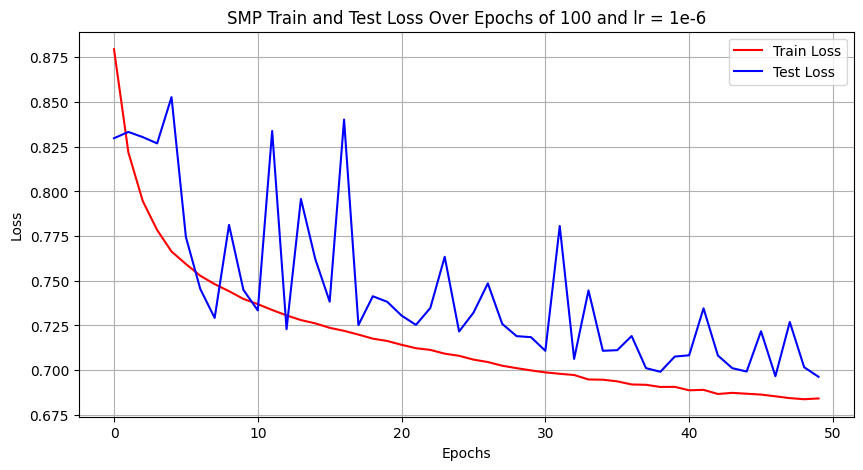

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(range(50), trained[0], label='Train Loss', color='red')
plt.plot(range(50), trained[1], label='Test Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SMP Train and Test Loss Over Epochs of 100 and lr = 1e-6')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()

t = 0
for images, masks in test_loader:

  images, masks = images.to(device), masks.to(device)
  outputs = model(images)

  outputs = outputs.cpu()
  masks = masks.cpu()

  for i in range(outputs.shape[0]):

    threshold = 0.5
    test_output = outputs[i].detach().numpy().transpose(1, 2, 0)
    binary_output = np.zeros(test_output.shape, dtype=np.uint8)
    binary_output[test_output > threshold] = 1

    image = images.cpu()

    image = image[i].detach().numpy().transpose(1, 2, 0)

    # just to stop strange colour things going on
    current_mask = masks[i].detach().numpy().transpose(1, 2, 0)
    if 0 not in current_mask:
      current_mask[0][0] = 0

    if 1 not in current_mask:
      current_mask[0][0] = 1

    fig, ax = plt.subplots(1, 4, figsize=(8, 3))

    ax[0].imshow(image, cmap='viridis')
    ax[0].set_title('Input')

    ax[1].imshow(test_output, cmap='viridis')
    ax[1].set_title('True Output')

    ax[2].imshow(binary_output, cmap='viridis')
    ax[2].set_title('Binary Output')

    ax[3].imshow(current_mask, cmap='viridis')
    ax[3].set_title('Mask')

    plt.show()
    break




In [29]:
import torch
import segmentation_models_pytorch as smp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = [1]
ACTIVATION = 'logit' # could be None for logits or 'softmax2d' for multiclass segmentation

# import segmentation_models_pytorch as smp

# create segmentation model with pretrained encoder
model_1 = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    decoder_use_batchnorm=True,
    encoder_depth=4,
    decoder_channels=(256, 128, 64, 32), #added the extra layer
)

ValueError: Activation should be callable/sigmoid/softmax/logsoftmax/tanh/argmax/argmax2d/clamp/None; got logit

In [30]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 1e-6
optimizer = Adam(model.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss()

def train(model, trainloader, testloader, criterion, optimizer, epochs, device):
  best_test = np.inf
  train_losses = []
  test_losses = []


  for epoch in range(epochs):
    epoch_loss = 0
    test_loss = 0

    model.train()
    for images, masks in tqdm(trainloader):

      images, masks = images.to(device), masks.to(device)

      optimizer.zero_grad()

      outputs = model(images)

      loss = criterion(outputs, masks)
      loss.backward()
      optimizer.step()
      loss = loss.cpu()
      epoch_loss += loss.item()

    model.eval()
    for image, masks in tqdm(testloader):
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)
      loss = criterion(outputs, masks)
      loss = loss.cpu()
      test_loss += loss.item()

      
    epoch_train_loss = epoch_loss / len(trainloader)
    epoch_test_loss = test_loss / len(testloader)

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)

    if test_loss/len(testloader) < best_test:
      best_test = test_loss/len(testloader)
      lr_str = str(lr)
      tile_size_str = str(tile_size)
      torch.save(model.state_dict(), 'smp_one_extra_layer_' + lr_str + "_" + tile_size_str + 'pth')

    print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(trainloader)}, Test Loss: {test_loss/len(testloader)}')

  return train_losses, test_losses

    # plt.figure(figsize=(10, 5))
    # plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='red')
    # plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='blue')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title('Train and Test Loss Over Epochs')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


In [31]:
model_1.to(device)
trained_1 = train(model_1, train_loader, test_loader, criterion, optimizer, 50, device)

100%|██████████| 223/223 [00:09<00:00, 24.11it/s]


Epoch 1, Train Loss: 0.9311368604567984, Test Loss: 0.9370193975923308


100%|██████████| 223/223 [00:08<00:00, 24.83it/s]


Epoch 2, Train Loss: 0.9312083554588986, Test Loss: 0.9380070238369997


100%|██████████| 223/223 [00:09<00:00, 23.94it/s]


Epoch 3, Train Loss: 0.9312300030497456, Test Loss: 0.9377615366281415


100%|██████████| 223/223 [00:10<00:00, 21.84it/s]


Epoch 4, Train Loss: 0.9311818755435622, Test Loss: 0.9405955394287281


100%|██████████| 223/223 [00:09<00:00, 23.57it/s]


Epoch 5, Train Loss: 0.9311445585538777, Test Loss: 0.9376948665610343


100%|██████████| 223/223 [00:08<00:00, 25.10it/s]


Epoch 6, Train Loss: 0.9311593295347811, Test Loss: 0.9409697253607848


100%|██████████| 223/223 [00:09<00:00, 24.74it/s]


Epoch 7, Train Loss: 0.9312170786755922, Test Loss: 0.9390771418408963


100%|██████████| 223/223 [00:09<00:00, 24.42it/s]


Epoch 8, Train Loss: 0.9312750353957667, Test Loss: 0.9434514069771018


100%|██████████| 223/223 [00:09<00:00, 24.15it/s]


Epoch 9, Train Loss: 0.9311906742193349, Test Loss: 0.9409056912623179


100%|██████████| 223/223 [00:09<00:00, 22.99it/s]


Epoch 10, Train Loss: 0.931306840193392, Test Loss: 0.9384883080897309


100%|██████████| 223/223 [00:09<00:00, 24.61it/s]


Epoch 11, Train Loss: 0.9312088517628936, Test Loss: 0.9377089765574366


100%|██████████| 223/223 [00:08<00:00, 25.14it/s]


Epoch 12, Train Loss: 0.9311608076095581, Test Loss: 0.9375333083050134


100%|██████████| 223/223 [00:08<00:00, 25.03it/s]


Epoch 13, Train Loss: 0.9310948029913083, Test Loss: 0.9378201279939558


100%|██████████| 223/223 [00:09<00:00, 24.65it/s]


Epoch 14, Train Loss: 0.9311318487163077, Test Loss: 0.9398669170157257


100%|██████████| 223/223 [00:09<00:00, 23.57it/s]


Epoch 15, Train Loss: 0.9311290127125921, Test Loss: 0.941231821417274


100%|██████████| 223/223 [00:08<00:00, 24.94it/s]


Epoch 16, Train Loss: 0.9311624663713671, Test Loss: 0.9376654836094432


100%|██████████| 223/223 [00:09<00:00, 23.82it/s]


Epoch 17, Train Loss: 0.9312192152780047, Test Loss: 0.9399115579545231


100%|██████████| 223/223 [00:10<00:00, 21.07it/s]


Epoch 18, Train Loss: 0.9313483375357725, Test Loss: 0.9403680172736335


100%|██████████| 223/223 [00:08<00:00, 25.03it/s]


Epoch 19, Train Loss: 0.9312079243788414, Test Loss: 0.9353958221294421


 90%|████████▉ | 799/891 [01:00<00:07, 13.14it/s]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(50), trained_1[0], label='Train Loss', color='red')
plt.plot(range(50), trained_1[1], label='Test Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SMP Train and Test Loss Over Epochs of 100 and lr = 1e-6')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()

t = 0
for images, masks in test_loader:

  images, masks = images.to(device), masks.to(device)
  outputs = model(images)

  outputs = outputs.cpu()
  masks = masks.cpu()

  for i in range(outputs.shape[0]):

    threshold = 0.5
    test_output = outputs[i].detach().numpy().transpose(1, 2, 0)
    binary_output = np.zeros(test_output.shape, dtype=np.uint8)
    binary_output[test_output > threshold] = 1

    image = images.cpu()

    image = image[i].detach().numpy().transpose(1, 2, 0)

    # just to stop strange colour things going on
    current_mask = masks[i].detach().numpy().transpose(1, 2, 0)
    if 0 not in current_mask:
      current_mask[0][0] = 0

    if 1 not in current_mask:
      current_mask[0][0] = 1

    fig, ax = plt.subplots(1, 4, figsize=(8, 3))

    ax[0].imshow(image, cmap='viridis')
    ax[0].set_title('Input')

    ax[1].imshow(test_output, cmap='viridis')
    ax[1].set_title('True Output')

    ax[2].imshow(binary_output, cmap='viridis')
    ax[2].set_title('Binary Output')

    ax[3].imshow(current_mask, cmap='viridis')
    ax[3].set_title('Mask')

    plt.show()
    break




In [ ]:
# model.eval()

# for images, masks in train_loader:
#   images, masks = images.to(device), masks.to(device)
#   outputs = model(images)

#   outputs = outputs.cpu()
#   masks = masks.cpu()

#   for i in range(outputs.shape[0]):

#     threshold = 0.5
#     test_output = outputs[i].detach().numpy().transpose(1, 2, 0)
#     binary_output = np.zeros(test_output.shape, dtype=np.uint8)
#     binary_output[test_output > threshold] = 1

#     fig, ax = plt.subplots(1, 4, figsize=(8, 3))

#     image = images.cpu()

#     image = image[i].detach().numpy().transpose(1, 2, 0)
#     print(np.max(image))
#     print(np.min(image))
#     ax[0].imshow(image, cmap='viridis')
#     ax[0].set_title('Input')

#     ax[1].imshow(test_output, cmap='viridis')
#     ax[1].set_title('True Output')

#     ax[2].imshow(binary_output, cmap='viridis')
#     ax[2].set_title('Binary Output')

#     # just to stop strange colour things going on
#     current_mask = masks[i].detach().numpy().transpose(1, 2, 0)
#     if 0 not in current_mask:
#       current_mask[0][0] = 0

#     if 1 not in current_mask:
#       current_mask[0][0] = 1

#     ax[3].imshow(current_mask, cmap='viridis')
#     ax[3].set_title('Mask')

#     plt.show()

#   #break

